In [1]:
from plotnine import *
import polars as pl
import duckdb

from typing import TypeAlias, Tuple

In [2]:
pithces_dataset = "hf://datasets/Jensen-holm/statcast-era-pitches/data/statcast_era_pitches.parquet"

con = duckdb.connect()

pitches_2024 = con.sql(
    f"""
    SELECT *
    FROM '{pithces_dataset}'
    WHERE game_date >= '2024-01-01 00:00:00'
    """
).pl()

con.close()

(pitches_2024
    .select("bat_speed", "swing_length")
    .describe())

statistic,bat_speed,swing_length
str,f64,f64
"""count""",321857.0,321857.0
"""null_count""",434280.0,434280.0
"""mean""",69.481781,7.216351
"""std""",8.886749,0.994753
"""min""",0.85121,0.30587
"""25%""",66.97682,6.64404
"""50%""",70.91698,7.27357
"""75%""",74.25351,7.88496
"""max""",87.99199,12.00067


## Adding Tunnel Score

$TunnelScore = log_{2}(\frac{ActualDistance}{TunnelDistance})$

**Where ...**

| Variable | Description |
|----------|-------------|
| **ActualDistance** | euclidean distance between actual pitch locations |
| **TunnelDistance** | euclidean distance between tunnel locations |
| **ReleaseDistance** | euclidean distance between release points |

$EuclideanDistance = \sqrt{((x_{1} - x_{2})^{2}) + ((y_{1} - y_{2})^{2})}$

In [3]:
# the first step is to tie every pitch to it's sequence
sorted_pitches_2024 = pitches_2024.sort(
    "game_date",
    "pitcher",
    "at_bat_number",
    "pitch_number",
)

for col_name in sorted_pitches_2024.columns:
    sorted_pitches_2024 = (
        sorted_pitches_2024
        .with_columns(
            pl.col(col_name)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{col_name}")
        )
    )

(sorted_pitches_2024
    .select(*[col for col in sorted_pitches_2024.columns if col.startswith("prev_")])
    .columns)

['prev_pitch_type',
 'prev_game_date',
 'prev_release_speed',
 'prev_release_pos_x',
 'prev_release_pos_z',
 'prev_player_name',
 'prev_batter',
 'prev_pitcher',
 'prev_events',
 'prev_description',
 'prev_spin_dir',
 'prev_spin_rate_deprecated',
 'prev_break_angle_deprecated',
 'prev_break_length_deprecated',
 'prev_zone',
 'prev_des',
 'prev_game_type',
 'prev_stand',
 'prev_p_throws',
 'prev_home_team',
 'prev_away_team',
 'prev_type',
 'prev_hit_location',
 'prev_bb_type',
 'prev_balls',
 'prev_strikes',
 'prev_game_year',
 'prev_pfx_x',
 'prev_pfx_z',
 'prev_plate_x',
 'prev_plate_z',
 'prev_on_3b',
 'prev_on_2b',
 'prev_on_1b',
 'prev_outs_when_up',
 'prev_inning',
 'prev_inning_topbot',
 'prev_hc_x',
 'prev_hc_y',
 'prev_tfs_deprecated',
 'prev_tfs_zulu_deprecated',
 'prev_fielder_2',
 'prev_umpire',
 'prev_sv_id',
 'prev_vx0',
 'prev_vy0',
 'prev_vz0',
 'prev_ax',
 'prev_ay',
 'prev_az',
 'prev_sz_top',
 'prev_sz_bot',
 'prev_hit_distance_sc',
 'prev_launch_speed',
 'prev_launc

In [9]:
Point: TypeAlias = Tuple[pl.Expr, pl.Expr]

def euclidean_distance(x: Point, y: Point) -> pl.Expr:
    return (((x[0] - x[1]) ** 2)
            + ((y[0] - y[1]) ** 2)) ** 0.5

tunnel_score_df = (
    sorted_pitches_2024

    # add tunnel location coordinates
    .with_columns(
        (pl.col("plate_x") - pl.col("pfx_x")).alias("tunnel_x"),
        (pl.col("plate_z") - pl.col("pfx_z")).alias("tunnel_z"),
        (pl.col("prev_plate_x") - pl.col("prev_pfx_x")).alias("prev_tunnel_x"),
        (pl.col("prev_plate_z") - pl.col("prev_pfx_z")).alias("prev_tunnel_z"),
    )

    # compute distances
    .with_columns(
        # tunnel distance
        (euclidean_distance(
            (pl.col("tunnel_x"), pl.col("tunnel_z")),
            (pl.col("prev_tunnel_x"), pl.col("prev_tunnel_z")),
        )).alias("tunnel_distance"),

        # actual distance
        (euclidean_distance(
            (pl.col("plate_x"), pl.col("plate_z")),
            (pl.col("prev_plate_x"), pl.col("prev_plate_z")),
        )).alias("actual_distance"),

        # release distance
        (euclidean_distance(
            (pl.col("release_pos_x"), pl.col("release_pos_z")),
            (pl.col("prev_release_pos_x"), pl.col("prev_release_pos_z")),
        )).alias("release_distance")
    )

    # add tunnel score itself
    .with_columns(
        ((pl.col("actual_distance") / pl.col("tunnel_distance")) - pl.col("release_distance")).log(2).alias("tunnel_score")
    )
)

(tunnel_score_df
    .select(
        "pitch_type",
        "prev_pitch_type",
        "tunnel_distance",
        "actual_distance",
        "release_distance",
        "tunnel_score",
    )
    .sample(5, seed=42))

pitch_type,prev_pitch_type,tunnel_distance,actual_distance,release_distance,tunnel_score
str,str,f64,f64,f64,f64
"""FF""","""FF""",4.155972,3.844698,3.090259,NaN
"""FC""","""FF""",3.761197,4.736127,6.176447,NaN
"""SI""","""SL""",3.20025,3.756647,11.789016,NaN
"""ST""","""ST""",0.60803,1.797804,1.297266,0.730753
"""SL""","""SL""",3.31006,2.460183,10.260141,NaN


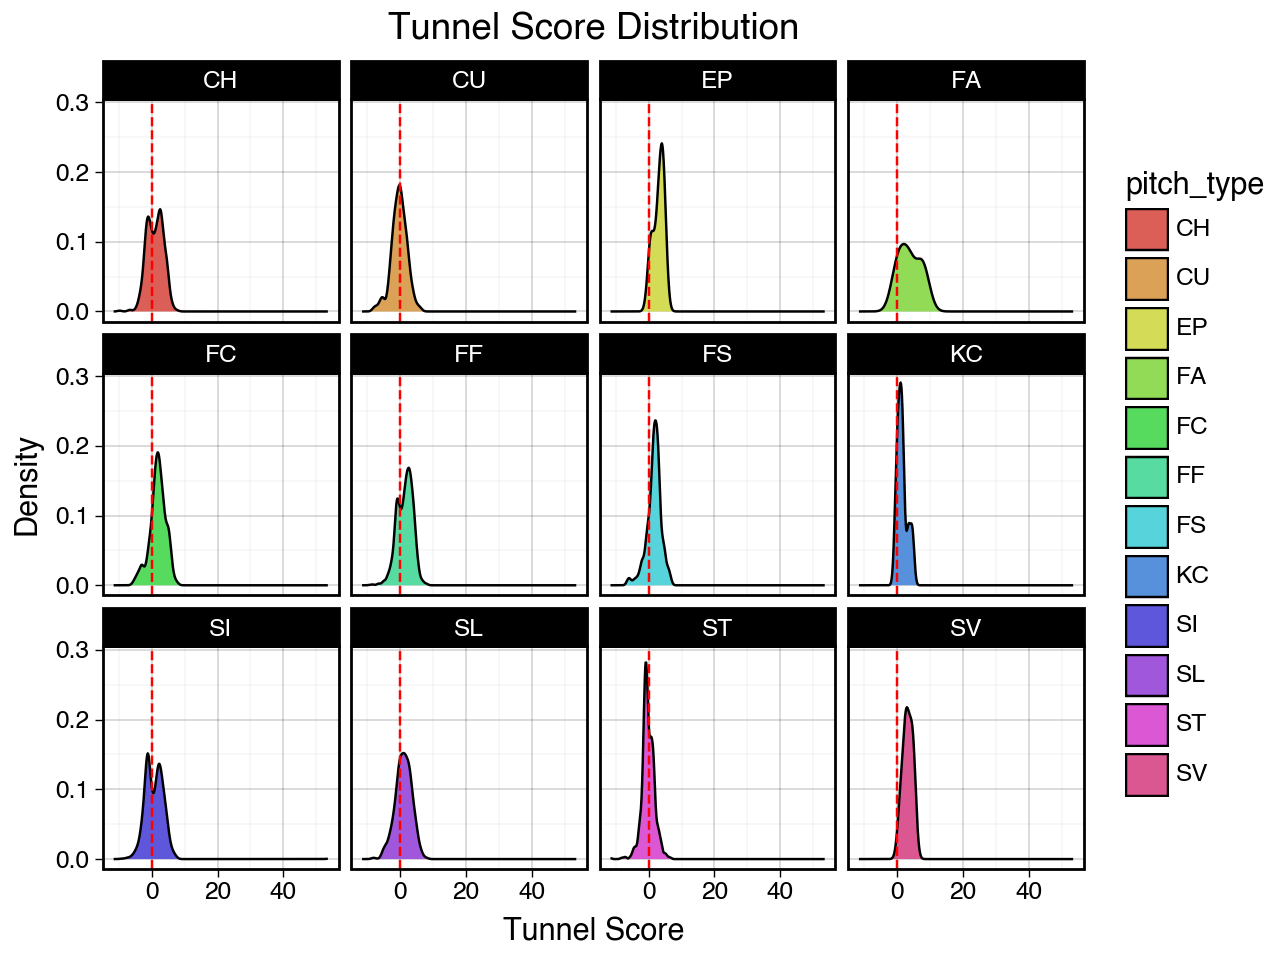

In [8]:
tunnel_score_dist_plot = (
    ggplot(
        (tunnel_score_df
         .drop_nulls(["tunnel_score"])
         .filter(pl.col("tunnel_score") < 1000)
         .filter(pl.col("pitch_type") != "KN")),
        aes(x="tunnel_score", fill="pitch_type")
    )
    + geom_density()
    + facet_wrap("~ pitch_type")
    + geom_vline(xintercept=0, color="red", linetype="dashed")
    + theme_linedraw()
    + labs(
        title="Tunnel Score Distribution",
        x="Tunnel Score",
        y="Density",
    )
)

tunnel_score_dist_plot.show()